#Imports e Dependências

In [55]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#Funções ETL

In [2]:
#Treat numeric values from dataframe
def str_to_num(df_aux, index):
  for i in index:
    col_name = df_aux.columns[i]
    df_aux[col_name] = df_aux[col_name].str.replace('.', '')
    df_aux[col_name] = df_aux[col_name].str.replace(',', '.')
    df_aux[col_name] = pd.to_numeric(df_aux[col_name])
  return df_aux


In [3]:
def get_data(url, id):
  url = (url)
  response = requests.get(url)
  print("Request: {} => {}".format(id, response))
  if response.status_code == 200:
    payload = response.json()
  else:
    print(url)
    print(f'Error {response.status_code}: {response.reason}')
  return payload

#Return dataframe movies/series from api informed
def retrieve_data_from_api(url, id):
  payload = get_data(url, id)
  return pd.DataFrame(payload["results"]), payload["page"], payload["total_pages"]

#Return dataframe cast (artists and directors) from api informed
def retrieve_data_cast_from_api(url, id):
  payload = get_data(url, id)
  return pd.DataFrame(payload["cast"]), pd.DataFrame(payload["crew"])

#Return dataframe details:
# TV:{ genres, last_air_date, number_of_episodes, number_of_seasons, status }
# Movie: { budget, genres, runtime, status }
def retrieve_data_detail_from_api(url, id, api_variables):
  payload = get_data(url, id)
  df_aux = pd.DataFrame(columns=api_variables)
  for x in api_variables:
    if x == 'genres':
      df_genres = pd.DataFrame(payload["genres"])
    else:
      df_aux.loc[0, x] = payload[x]
  return df_aux, df_genres

In [4]:
#Reference: https://www.themoviedb.org/documentation/api
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "?api_key=c9fd270fb257dd3be3a6cc9eac4b81a6"
DEFAULT_LANGUAGE = "&language=en-US"
PAGE = "&page="

def build_themoviedb_url(request_type, page):
  uri = BASE_URL + request_type + API_KEY + DEFAULT_LANGUAGE 
  if page > 0:
    uri = uri + PAGE + str(page)
  return uri

#http://api.themoviedb.org/3/movie/550/casts?api_key=c9fd270fb257dd3be3a6cc9eac4b81a6
#https://api.themoviedb.org/3/tv/88040/credits?api_key=c9fd270fb257dd3be3a6cc9eac4b81a6
def build_themoviedb_cast_url(request_type, api_variable, movie_id):
  uri = BASE_URL + request_type +  str(movie_id) + api_variable + API_KEY
  return uri

#https://api.themoviedb.org/3/movie/500?api_key=c9fd270fb257dd3be3a6cc9eac4b81a6&language=en-US
def build_themoviedb_details_url(request_type, movie_id):
  uri = BASE_URL + request_type +  str(movie_id) + API_KEY
  return uri

In [5]:
def load_all_themoviedb(request):
  print(request)
  current_page = 0
  total_pages = 1
  while current_page <= total_pages:
    uri = build_themoviedb_url(request, current_page)
    df_aux, current_page, total_pages = retrieve_data_from_api(uri, current_page)
    if current_page == 1:
      print("TOTAL: ", total_pages)
      df = pd.DataFrame(df_aux)
    else:
      df = df.append(df_aux, ignore_index=True)
    current_page = current_page+1
  print("DONE!")
  return df

def load_all_cast_themoviedb(request, api_variable, df_aux):
  col_cast = ['id', 'Casting', 'Crew']
  df_cast = pd.DataFrame(columns=col_cast)
  for index, row in df_aux.iterrows():
    movie_id = row['id']
    uri = build_themoviedb_cast_url(request, api_variable, movie_id)
    df_art, df_dir = retrieve_data_cast_from_api(uri, movie_id)
    #get Acting department
    artists = get_department(df_art, 'known_for_department', 'Acting')
    #get Directing department
    directors = get_department(df_dir, 'department', 'Directing')
    data = [{col_cast[0]: movie_id, 
            col_cast[1]: get_string_of_series(artists),
            col_cast[2]: get_string_of_series(directors)}]
    df_cast = df_cast.append(pd.DataFrame(data), ignore_index=True)
  #merge with main dataframe  
  df_aux = df_aux.merge(df_cast, on='id')
  return df_aux

def load_details_themoviedb(request, api_variables, df_aux):
  df_details = pd.DataFrame(columns=api_variables)
  for index, row in df_aux.iterrows():
    movie_id = row['id']
    uri = build_themoviedb_details_url(request, movie_id)
    df_det, df_genres = retrieve_data_detail_from_api(uri, movie_id, api_variables)
    #get name of genres
    if 'name' in df_genres:
      genres = get_string_of_series(df_genres['name'])
    else:
      genres = ''
    df_det.loc[0, 'genres'] = genres
    #append details of movie or serie
    df_details = df_details.append(df_det, ignore_index=True)
  #merge with main dataframe  
  df_aux = df_aux.merge(df_details, on='id')
  return df_aux

def get_department(df, column, department):
  if column in df:
    aux = df[df[column] == department]
    return aux['name']
  else:
    return ''

def get_string_of_series(serie):
  aux = ''
  for x in serie:
    aux = aux + x + ';'
  return aux[:-1]


In [6]:
def get_netflix_dataset():
  !wget https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/netflix_titles.csv?raw=true
  !ls -la
  #rename
  !mv 'netflix_titles.csv?raw=true' 'netflix_titles.csv'
  df = pd.read_csv('./netflix_titles.csv', sep = ",", usecols = ["type", "title", "director", "cast", "country", "date_added", "release_year", "rating", "duration", "listed_in", "description"])
  return df

def get_movies_dataset():
  !wget https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/movies.csv?raw=true
  !ls -la
  #rename
  !mv 'movies.csv?raw=true' 'movies.csv'
  df = pd.read_csv('./movies.csv', sep = ",")
  return df

def get_series_dataset():
  !wget https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/series.csv?raw=true
  !ls -la
  #rename
  !mv 'series.csv?raw=true' 'series.csv'
  df = pd.read_csv('./series.csv', sep = ",")
  return df

##Métodos para checagem de **outliers**

In [7]:
def tukeys_method(df):
  # Parâmetros: series
  q1 = np.quantile(df, 0.25)
  q3 = np.quantile(df, 0.75)
  iqr = q3-q1
  inner_fence = 1.5*iqr
  outer_fence = 3*iqr

  #inner fence lower and uper end
  inner_fence_le = q1-inner_fence
  inner_fence_ue = q3+inner_fence

  #outer fence lower and uper end
  outer_fence_le = q1-outer_fence
  outer_fence_ue = q3+outer_fence

  outliers_prob = []
  outliers_poss = []
  for index, x in enumerate(df):
    if x <= outer_fence_le or x >= outer_fence_ue:
      outliers_prob.append(index)
  for index, x in enumerate(df):
    if x <= inner_fence_le or x >= inner_fence_ue:
      outliers_poss.append(index)
  return outliers_prob, outliers_poss

#Extração dos dados

1.   Filmes - [the movie database](https://www.themoviedb.org/)
2.   Série - [the movie database](https://www.themoviedb.org/)
3.   Netflix - [Kaggle](https://www.kaggle.com/shivamb/netflix-shows)

In [ ]:
#Movies
df_movies = load_all_themoviedb("movie/top_rated")
df_movies.info()

movie/top_rated
Request: 0 => <Response [200]>
TOTAL:  423
Request: 2 => <Response [200]>
Request: 3 => <Response [200]>
Request: 4 => <Response [200]>
Request: 5 => <Response [200]>
Request: 6 => <Response [200]>
Request: 7 => <Response [200]>
Request: 8 => <Response [200]>
Request: 9 => <Response [200]>
Request: 10 => <Response [200]>
Request: 11 => <Response [200]>
Request: 12 => <Response [200]>
Request: 13 => <Response [200]>
Request: 14 => <Response [200]>
Request: 15 => <Response [200]>
Request: 16 => <Response [200]>
Request: 17 => <Response [200]>
Request: 18 => <Response [200]>
Request: 19 => <Response [200]>
Request: 20 => <Response [200]>
Request: 21 => <Response [200]>
Request: 22 => <Response [200]>
Request: 23 => <Response [200]>
Request: 24 => <Response [200]>
Request: 25 => <Response [200]>
Request: 26 => <Response [200]>
Request: 27 => <Response [200]>
Request: 28 => <Response [200]>
Request: 29 => <Response [200]>
Request: 30 => <Response [200]>
Request: 31 => <Respo

In [ ]:
#Series
df_series = load_all_themoviedb("tv/top_rated")
df_series.info()

tv/top_rated
Request: 0 => <Response [200]>
TOTAL:  84
Request: 2 => <Response [200]>
Request: 3 => <Response [200]>
Request: 4 => <Response [200]>
Request: 5 => <Response [200]>
Request: 6 => <Response [200]>
Request: 7 => <Response [200]>
Request: 8 => <Response [200]>
Request: 9 => <Response [200]>
Request: 10 => <Response [200]>
Request: 11 => <Response [200]>
Request: 12 => <Response [200]>
Request: 13 => <Response [200]>
Request: 14 => <Response [200]>
Request: 15 => <Response [200]>
Request: 16 => <Response [200]>
Request: 17 => <Response [200]>
Request: 18 => <Response [200]>
Request: 19 => <Response [200]>
Request: 20 => <Response [200]>
Request: 21 => <Response [200]>
Request: 22 => <Response [200]>
Request: 23 => <Response [200]>
Request: 24 => <Response [200]>
Request: 25 => <Response [200]>
Request: 26 => <Response [200]>
Request: 27 => <Response [200]>
Request: 28 => <Response [200]>
Request: 29 => <Response [200]>
Request: 30 => <Response [200]>
Request: 31 => <Response 

##Extração de Dados de filmes e séries



###**Elenco:**
*   Atores
*   Diretores



In [ ]:
#Movies
df_movies = load_all_cast_themoviedb("movie/", "/casts", df_movies)
df_movies

Streaming output truncated to the last 5000 lines.
Request: 15144 => <Response [200]>
Request: 9538 => <Response [200]>
Request: 401200 => <Response [200]>
Request: 446894 => <Response [200]>
Request: 11381 => <Response [200]>
Request: 7874 => <Response [200]>
Request: 2255 => <Response [200]>
Request: 95 => <Response [200]>
Request: 347866 => <Response [200]>
Request: 72190 => <Response [200]>
Request: 16995 => <Response [200]>
Request: 10934 => <Response [200]>
Request: 539892 => <Response [200]>
Request: 11071 => <Response [200]>
Request: 10846 => <Response [200]>
Request: 9433 => <Response [200]>
Request: 9058 => <Response [200]>
Request: 615774 => <Response [200]>
Request: 227973 => <Response [200]>
Request: 2266 => <Response [200]>
Request: 467956 => <Response [200]>
Request: 348765 => <Response [200]>
Request: 296524 => <Response [200]>
Request: 37137 => <Response [200]>
Request: 33908 => <Response [200]>
Request: 12573 => <Response [200]>
Request: 159824 => <Response [200]>
Req

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,Casting,Crew
0,False,/fQq1FWp1rC89xDrRMuyFJdFUdMd.jpg,"[10749, 35]",761053,en,Gabriel's Inferno Part III,The final part of the film adaption of the ero...,33.315,/fYtHxTxlhzD4QWfEbrC1rypysSD.jpg,2020-11-19,Gabriel's Inferno Part III,False,8.8,725,Giulio Berruti;Rhett Wellington;Melanie Zanett...,Tosca Musk
1,False,/jtAI6OJIWLWiRItNSZoWjrsUtmi.jpg,[10749],724089,en,Gabriel's Inferno Part II,Professor Gabriel Emerson finally learns the t...,9.365,/pci1ArYW7oJ2eyTo2NMYEKHHiCP.jpg,2020-07-31,Gabriel's Inferno Part II,False,8.8,1179,Melanie Zanetti;Giulio Berruti;James Andrew Fr...,Tosca Musk
2,False,/xRI636TOdS1K1GBqIBRSmfZ1T5x.jpg,"[35, 18, 10749]",19404,hi,दिलवाले दुल्हनिया ले जायेंगे,"Raj is a rich, carefree, happy-go-lucky second...",15.250,/2CAL2433ZeIihfX1Hb2139CX0pW.jpg,1995-10-20,Dilwale Dulhania Le Jayenge,False,8.8,2663,Shah Rukh Khan;Kajol;Amrish Puri;Anupam Kher;S...,Aditya Chopra
3,False,/mxn0RJ6stopje13MZdwU35XDnAx.jpg,"[10751, 12, 16, 14]",441130,en,Wolfwalkers,"In a time of superstition and magic, when wolv...",28.370,/ehAKuE48okTuonq6TpsNQj8vFTC.jpg,2020-10-26,Wolfwalkers,False,8.7,258,Honor Kneafsey;Eva Whittaker;Sean Bean;Simon M...,Tomm Moore;Ross Stewart;Mark Mullery
4,False,/tXHpvlr5F7gV5DwgS7M5HBrUi2C.jpg,"[18, 80]",278,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,54.041,/q6y0Go1tsGEsmtFryDOJo3dEmqu.jpg,1994-09-23,The Shawshank Redemption,False,8.7,18389,Tim Robbins;Morgan Freeman;Bob Gunton;William ...,Frank Darabont;Sioux Richards;Jesse V. Johnson...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8436,False,/teEvOq9KVz5HX1mHIWlZ965p9zT.jpg,[35],13805,en,Disaster Movie,"The filmmaking team behind the hits ""Scary Mov...",13.263,/3J8XKUfhJiNzwobUZVtizXYPe8b.jpg,2008-08-29,Disaster Movie,False,3.2,707,Matt Lanter;Vanessa Lachey;Tony Cox;Tad Hilgen...,Jason Friedberg;Aaron Seltzer
8437,False,/hqJfW8G8FL28rckFHuCoKPecpG9.jpg,"[28, 12, 878, 10752]",5491,en,Battlefield Earth,"In the year 3000, man is no match for the Psyc...",8.540,/neMUscYddxr4cP8wnRHRMLcWS0A.jpg,2000-05-12,Battlefield Earth,False,3.0,533,John Travolta;Barry Pepper;Forest Whitaker;Kim...,Roger Christian
8438,False,/oHrrgAPEKpz0S1ofQntiZNrmGrM.jpg,"[28, 12, 14, 878, 53]",14164,en,Dragonball Evolution,The young warrior Son Goku sets out on a quest...,31.988,/jcZBiSNgiIIBnmRAj7lkGPk2Nyk.jpg,2009-03-12,Dragonball Evolution,False,2.8,1429,Justin Chatwin;Chow Yun-Fat;Joon Park;Jamie Ch...,James Wong
8439,False,/aNUEHLNsNMprLZt6fjf5nqDq6er.jpg,"[27, 28, 53]",11059,en,House of the Dead,"Set on an island off the coast, a techno rave ...",9.737,/lI6UBnxwHztggSq8PhLibdOe2Nd.jpg,2003-04-11,House of the Dead,False,2.8,236,Jonathan Cherry;Tyron Leitso;Clint Howard;Ona ...,Uwe Boll;Bryan C. Knight;Dean Choe;Patti Hende...


In [ ]:
#Series
df_series = load_all_cast_themoviedb("tv/", "/credits", df_series)
df_series

Request: 100 => <Response [200]>
Request: 88040 => <Response [200]>
Request: 83097 => <Response [200]>
Request: 100049 => <Response [200]>
Request: 83095 => <Response [200]>
Request: 80564 => <Response [200]>
Request: 99071 => <Response [200]>
Request: 61663 => <Response [200]>
Request: 93019 => <Response [200]>
Request: 96316 => <Response [200]>
Request: 68129 => <Response [200]>
Request: 73055 => <Response [200]>
Request: 96150 => <Response [200]>
Request: 65648 => <Response [200]>
Request: 65930 => <Response [200]>
Request: 67389 => <Response [200]>
Request: 87432 => <Response [200]>
Request: 83121 => <Response [200]>
Request: 72636 => <Response [200]>
Request: 68188 => <Response [200]>
Request: 90447 => <Response [200]>
Request: 68349 => <Response [200]>
Request: 60863 => <Response [200]>
Request: 85937 => <Response [200]>
Request: 95269 => <Response [200]>
Request: 77721 => <Response [200]>
Request: 45950 => <Response [200]>
Request: 84669 => <Response [200]>
Request: 76121 => <Re

,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,overview,popularity,poster_path,vote_average,vote_count,Casting,Crew
0,None,2004-05-10,"[16, 35]",100,I Am Not an Animal,[GB],en,I Am Not an Animal,I Am Not An Animal is an animated comedy serie...,12.076,/qG59J1Q7rpBc1dvku4azbzcqo8h.jpg,9.4,598,Julia Davis;Kevin Eldon;Simon Pegg;Steve Cooga...,
1,/7gbmM2NWcqZONbp65HUWDf4wr0Q.jpg,2019-07-12,"[16, 18]",88040,Given,[JP],ja,ギヴン,"Tightly clutching his Gibson guitar, Mafuyu Sa...",28.498,/pdDCcAq8RNSZNk81PXYoHNUPHjn.jpg,9.2,391,Fumiya Imai;Shougo Yano;Takuya Eguchi;Masatomo...,Hikaru Yamaguchi
2,/uAjMQlbPkVHmUahhCouANlHSDW2.jpg,2019-01-11,"[16, 9648, 10765, 10759, 18]",83097,The Promised Neverland,[JP],ja,約束のネバーランド,"Surrounded by a forest and a gated entrance, t...",65.812,/yxdeII5tI8qqiERcMxjW9DfB6Gz.jpg,9.2,545,Sumire Morohoshi;Mariya Ise;Lynn;Shinei Ueki;E...,
3,/rnf2BDKeF1sxPEPhAcdvL0auuxr.jpg,2020-10-03,"[16, 35]",100049,TONIKAWA: Over the Moon for You,[JP],ja,トニカクカワイイ,"First comes marriage, then comes an earthbound...",32.649,/n1oOuXlcHF1brgcgyiwmnIODXso.jpg,9.1,176,Junya Enoki;Akari Kitō;Yū Serizawa;Sumire Uesa...,Hiroshi Ikehata
4,/qSgBzXdu6QwVVeqOYOlHolkLRxZ.jpg,2019-01-09,"[16, 10759, 10765, 18]",83095,The Rising of the Shield Hero,[JP],ja,盾の勇者の成り上がり,Iwatani Naofumi was summoned into a parallel w...,15.476,/6cXf5EDwVhsRv8GlBzUTVnWuk8Z.jpg,9.1,457,Kaito Ishikawa;Asami Seto;Rina Hidaka;Hiroki Y...,Takao Abo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,/kY8ciI1pR2sJrkZeGpR1gNxxGfB.jpg,2000-07-05,[10764],10160,Big Brother,[US],en,Big Brother,American version of the reality game show whic...,24.067,/3z1eKtApXsr0FbQAoHX0F8ATwZO.jpg,4.9,173,Julie Chen Moonves,
1657,/qnTBxxv7q4xVwgZBLb0vtILLelh.jpg,2007-10-14,[10764],14814,Keeping Up with the Kardashians,[US],en,Keeping Up with the Kardashians,A peek inside the exploits and privileged priv...,51.804,/l7QHRrX1EYgQAzNJdCdoEQHoHJ.jpg,4.8,226,Kim Kardashian West;Khloé Kardashian;Kourtney ...,
1658,/dHlKH9vTumj7tPBeYVWGzI7UJ9I.jpg,1975-04-05,"[10759, 10765, 9648, 18]",45253,Super Sentai,[JP],ja,スーパー戦隊シリーズ,The Super Sentai Series is the name given to t...,29.646,/tDq8av51oHR8YWgkiHQ2oeRO5iL.jpg,4.7,104,Rio Komiya;Rui Kihara;Yume Shinjo;Atomu Mizuis...,
1659,/hUz0UHWSVd6e1g3I6vT4shAsnoY.jpg,1985-02-19,"[10766, 18]",1871,EastEnders,[GB],en,EastEnders,The everyday lives of working-class residents ...,27.180,/z4jgyI5TpoRZiJTNchkVkMrGQyz.jpg,3.8,165,,


###**Classificação e demais informações**
Filmes:
*   Gênero
*   Budget
*   Duração
*   Status

Séries:
*   Gênero
*   Última data no ar
*   Número de episódios
*   Número de temporadas
*   Status

In [ ]:
df_movies = load_details_themoviedb("movie/", ["id","budget", "genres", "runtime", "status"], df_movies)
df_movies

Streaming output truncated to the last 5000 lines.
Request: 15144 => <Response [200]>
Request: 9538 => <Response [200]>
Request: 401200 => <Response [200]>
Request: 446894 => <Response [200]>
Request: 11381 => <Response [200]>
Request: 7874 => <Response [200]>
Request: 2255 => <Response [200]>
Request: 95 => <Response [200]>
Request: 347866 => <Response [200]>
Request: 72190 => <Response [200]>
Request: 16995 => <Response [200]>
Request: 10934 => <Response [200]>
Request: 539892 => <Response [200]>
Request: 11071 => <Response [200]>
Request: 10846 => <Response [200]>
Request: 9433 => <Response [200]>
Request: 9058 => <Response [200]>
Request: 615774 => <Response [200]>
Request: 227973 => <Response [200]>
Request: 2266 => <Response [200]>
Request: 467956 => <Response [200]>
Request: 348765 => <Response [200]>
Request: 296524 => <Response [200]>
Request: 37137 => <Response [200]>
Request: 33908 => <Response [200]>
Request: 12573 => <Response [200]>
Request: 159824 => <Response [200]>
Req

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,Casting,Crew,budget,genres,runtime,status
0,False,/fQq1FWp1rC89xDrRMuyFJdFUdMd.jpg,"[10749, 35]",761053,en,Gabriel's Inferno Part III,The final part of the film adaption of the ero...,33.315,/fYtHxTxlhzD4QWfEbrC1rypysSD.jpg,2020-11-19,Gabriel's Inferno Part III,False,8.8,725,Giulio Berruti;Rhett Wellington;Melanie Zanett...,Tosca Musk,0,Romance;Comedy,105,Released
1,False,/jtAI6OJIWLWiRItNSZoWjrsUtmi.jpg,[10749],724089,en,Gabriel's Inferno Part II,Professor Gabriel Emerson finally learns the t...,9.365,/pci1ArYW7oJ2eyTo2NMYEKHHiCP.jpg,2020-07-31,Gabriel's Inferno Part II,False,8.8,1179,Melanie Zanetti;Giulio Berruti;James Andrew Fr...,Tosca Musk,0,Romance,105,Released
2,False,/xRI636TOdS1K1GBqIBRSmfZ1T5x.jpg,"[35, 18, 10749]",19404,hi,दिलवाले दुल्हनिया ले जायेंगे,"Raj is a rich, carefree, happy-go-lucky second...",15.250,/2CAL2433ZeIihfX1Hb2139CX0pW.jpg,1995-10-20,Dilwale Dulhania Le Jayenge,False,8.8,2663,Shah Rukh Khan;Kajol;Amrish Puri;Anupam Kher;S...,Aditya Chopra,13200000,Comedy;Drama;Romance,190,Released
3,False,/mxn0RJ6stopje13MZdwU35XDnAx.jpg,"[10751, 12, 16, 14]",441130,en,Wolfwalkers,"In a time of superstition and magic, when wolv...",28.370,/ehAKuE48okTuonq6TpsNQj8vFTC.jpg,2020-10-26,Wolfwalkers,False,8.7,258,Honor Kneafsey;Eva Whittaker;Sean Bean;Simon M...,Tomm Moore;Ross Stewart;Mark Mullery,0,Family;Adventure;Animation;Fantasy,103,Released
4,False,/tXHpvlr5F7gV5DwgS7M5HBrUi2C.jpg,"[18, 80]",278,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,54.041,/q6y0Go1tsGEsmtFryDOJo3dEmqu.jpg,1994-09-23,The Shawshank Redemption,False,8.7,18389,Tim Robbins;Morgan Freeman;Bob Gunton;William ...,Frank Darabont;Sioux Richards;Jesse V. Johnson...,25000000,Drama;Crime,142,Released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8436,False,/teEvOq9KVz5HX1mHIWlZ965p9zT.jpg,[35],13805,en,Disaster Movie,"The filmmaking team behind the hits ""Scary Mov...",13.263,/3J8XKUfhJiNzwobUZVtizXYPe8b.jpg,2008-08-29,Disaster Movie,False,3.2,707,Matt Lanter;Vanessa Lachey;Tony Cox;Tad Hilgen...,Jason Friedberg;Aaron Seltzer,25000000,Comedy,87,Released
8437,False,/hqJfW8G8FL28rckFHuCoKPecpG9.jpg,"[28, 12, 878, 10752]",5491,en,Battlefield Earth,"In the year 3000, man is no match for the Psyc...",8.540,/neMUscYddxr4cP8wnRHRMLcWS0A.jpg,2000-05-12,Battlefield Earth,False,3.0,533,John Travolta;Barry Pepper;Forest Whitaker;Kim...,Roger Christian,44000000,Action;Adventure;Science Fiction;War,118,Released
8438,False,/oHrrgAPEKpz0S1ofQntiZNrmGrM.jpg,"[28, 12, 14, 878, 53]",14164,en,Dragonball Evolution,The young warrior Son Goku sets out on a quest...,31.988,/jcZBiSNgiIIBnmRAj7lkGPk2Nyk.jpg,2009-03-12,Dragonball Evolution,False,2.8,1429,Justin Chatwin;Chow Yun-Fat;Joon Park;Jamie Ch...,James Wong,100000000,Action;Adventure;Fantasy;Science Fiction;Thriller,85,Released
8439,False,/aNUEHLNsNMprLZt6fjf5nqDq6er.jpg,"[27, 28, 53]",11059,en,House of the Dead,"Set on an island off the coast, a techno rave ...",9.737,/lI6UBnxwHztggSq8PhLibdOe2Nd.jpg,2003-04-11,House of the Dead,False,2.8,236,Jonathan Cherry;Tyron Leitso;Clint Howard;Ona ...,Uwe Boll;Bryan C. Knight;Dean Choe;Patti Hende...,7000000,Horror;Action;Thriller,90,Released


In [ ]:
df_series = load_details_themoviedb("tv/", ["id", "genres", "last_air_date", "number_of_episodes", "number_of_seasons", "status"], df_series)
df_series

Request: 100 => <Response [200]>
Request: 88040 => <Response [200]>
Request: 83097 => <Response [200]>
Request: 100049 => <Response [200]>
Request: 83095 => <Response [200]>
Request: 80564 => <Response [200]>
Request: 99071 => <Response [200]>
Request: 61663 => <Response [200]>
Request: 93019 => <Response [200]>
Request: 96316 => <Response [200]>
Request: 68129 => <Response [200]>
Request: 73055 => <Response [200]>
Request: 96150 => <Response [200]>
Request: 65648 => <Response [200]>
Request: 65930 => <Response [200]>
Request: 67389 => <Response [200]>
Request: 87432 => <Response [200]>
Request: 83121 => <Response [200]>
Request: 72636 => <Response [200]>
Request: 68188 => <Response [200]>
Request: 90447 => <Response [200]>
Request: 68349 => <Response [200]>
Request: 60863 => <Response [200]>
Request: 85937 => <Response [200]>
Request: 95269 => <Response [200]>
Request: 77721 => <Response [200]>
Request: 45950 => <Response [200]>
Request: 84669 => <Response [200]>
Request: 76121 => <Re

,backdrop_path,first_air_date,genre_ids,id,name,origin_country,original_language,original_name,overview,popularity,poster_path,vote_average,vote_count,Casting,Crew,genres,last_air_date,number_of_episodes,number_of_seasons,status
0,None,2004-05-10,"[16, 35]",100,I Am Not an Animal,[GB],en,I Am Not an Animal,I Am Not An Animal is an animated comedy serie...,12.076,/qG59J1Q7rpBc1dvku4azbzcqo8h.jpg,9.4,598,Julia Davis;Kevin Eldon;Simon Pegg;Steve Cooga...,,Animation;Comedy,2004-06-14,6,1,Ended
1,/7gbmM2NWcqZONbp65HUWDf4wr0Q.jpg,2019-07-12,"[16, 18]",88040,Given,[JP],ja,ギヴン,"Tightly clutching his Gibson guitar, Mafuyu Sa...",28.498,/pdDCcAq8RNSZNk81PXYoHNUPHjn.jpg,9.2,391,Fumiya Imai;Shougo Yano;Takuya Eguchi;Masatomo...,Hikaru Yamaguchi,Animation;Drama,2019-09-20,11,1,Ended
2,/uAjMQlbPkVHmUahhCouANlHSDW2.jpg,2019-01-11,"[16, 9648, 10765, 10759, 18]",83097,The Promised Neverland,[JP],ja,約束のネバーランド,"Surrounded by a forest and a gated entrance, t...",65.812,/yxdeII5tI8qqiERcMxjW9DfB6Gz.jpg,9.2,545,Sumire Morohoshi;Mariya Ise;Lynn;Shinei Ueki;E...,,Animation;Mystery;Sci-Fi & Fantasy;Action & Ad...,2021-02-26,23,2,Returning Series
3,/rnf2BDKeF1sxPEPhAcdvL0auuxr.jpg,2020-10-03,"[16, 35]",100049,TONIKAWA: Over the Moon for You,[JP],ja,トニカクカワイイ,"First comes marriage, then comes an earthbound...",32.649,/n1oOuXlcHF1brgcgyiwmnIODXso.jpg,9.1,176,Junya Enoki;Akari Kitō;Yū Serizawa;Sumire Uesa...,Hiroshi Ikehata,Animation;Comedy,2020-12-19,12,1,Ended
4,/qSgBzXdu6QwVVeqOYOlHolkLRxZ.jpg,2019-01-09,"[16, 10759, 10765, 18]",83095,The Rising of the Shield Hero,[JP],ja,盾の勇者の成り上がり,Iwatani Naofumi was summoned into a parallel w...,15.476,/6cXf5EDwVhsRv8GlBzUTVnWuk8Z.jpg,9.1,457,Kaito Ishikawa;Asami Seto;Rina Hidaka;Hiroki Y...,Takao Abo,Animation;Action & Adventure;Sci-Fi & Fantasy;...,2019-06-26,25,2,Returning Series
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,/kY8ciI1pR2sJrkZeGpR1gNxxGfB.jpg,2000-07-05,[10764],10160,Big Brother,[US],en,Big Brother,American version of the reality game show whic...,24.067,/3z1eKtApXsr0FbQAoHX0F8ATwZO.jpg,4.9,173,Julie Chen Moonves,,Reality,2020-10-28,783,22,Returning Series
1657,/qnTBxxv7q4xVwgZBLb0vtILLelh.jpg,2007-10-14,[10764],14814,Keeping Up with the Kardashians,[US],en,Keeping Up with the Kardashians,A peek inside the exploits and privileged priv...,51.804,/l7QHRrX1EYgQAzNJdCdoEQHoHJ.jpg,4.8,226,Kim Kardashian West;Khloé Kardashian;Kourtney ...,,Reality,2020-11-12,270,20,Returning Series
1658,/dHlKH9vTumj7tPBeYVWGzI7UJ9I.jpg,1975-04-05,"[10759, 10765, 9648, 18]",45253,Super Sentai,[JP],ja,スーパー戦隊シリーズ,The Super Sentai Series is the name given to t...,29.646,/tDq8av51oHR8YWgkiHQ2oeRO5iL.jpg,4.7,104,Rio Komiya;Rui Kihara;Yume Shinjo;Atomu Mizuis...,,Action & Adventure;Sci-Fi & Fantasy;Mystery;Drama,2021-02-21,2212,44,Returning Series
1659,/hUz0UHWSVd6e1g3I6vT4shAsnoY.jpg,1985-02-19,"[10766, 18]",1871,EastEnders,[GB],en,EastEnders,The everyday lives of working-class residents ...,27.180,/z4jgyI5TpoRZiJTNchkVkMrGQyz.jpg,3.8,165,,,Soap;Drama,2021-02-26,6155,37,Returning Series


##Salvar em CSV 

In [ ]:
df_movies.to_csv(r'movies.csv', index = False)

In [ ]:
df_series.to_csv(r'series.csv', index = False)

#Carregamento de dados do repositório

In [8]:
#Netflix
df_netflix = get_netflix_dataset()
df_netflix.info()

--2021-03-04 23:48:40--  https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/netflix_titles.csv?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/netflix_titles.csv [following]
--2021-03-04 23:48:41--  https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/netflix_titles.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/netflix_titles.csv [following]
--2021-03-04 23:48:41--  https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/netflix_titles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to r

In [9]:
#Movies
df_movies = get_movies_dataset()
df_movies.info()

--2021-03-04 23:48:53--  https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/movies.csv?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/movies.csv [following]
--2021-03-04 23:48:53--  https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/movies.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/movies.csv [following]
--2021-03-04 23:48:53--  https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [10]:
#Movies
df_series = get_series_dataset()
df_series.info()

--2021-03-04 23:49:00--  https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/series.csv?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/series.csv [following]
--2021-03-04 23:49:00--  https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/series.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/series.csv [following]
--2021-03-04 23:49:00--  https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/series.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

# Transformação

**Integração dos Dados**

In [11]:
data_lake = pd.concat([df_movies, df_netflix, df_series], ignore_index=True, sort=False)

**Normalizando atributos correspondentes**

In [12]:
#DataFrame Sreies tem o aatributo name, diferente dos outros que possui atributo title
data_lake.loc[data_lake['title'].isnull(), 'title'] = data_lake['name']

**Removedo atributos não necessários para análise**

In [13]:
data_lake.drop(columns=['id', 'backdrop_path', 'poster_path', 'name', 'original_title'], inplace=True)

In [14]:
data_lake

,adult,genre_ids,original_language,overview,popularity,release_date,title,video,vote_average,vote_count,Casting,Crew,budget,genres,runtime,status,type,director,cast,country,date_added,release_year,rating,duration,listed_in,description,first_air_date,origin_country,original_name,last_air_date,number_of_episodes,number_of_seasons
0,False,"[10749, 35]",en,The final part of the film adaption of the ero...,33.315,2020-11-19,Gabriel's Inferno Part III,False,8.8,725.0,Giulio Berruti;Rhett Wellington;Melanie Zanett...,Tosca Musk,0.0,Romance;Comedy,105.0,Released,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,[10749],en,Professor Gabriel Emerson finally learns the t...,9.365,2020-07-31,Gabriel's Inferno Part II,False,8.8,1179.0,Melanie Zanetti;Giulio Berruti;James Andrew Fr...,Tosca Musk,0.0,Romance,105.0,Released,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,"[35, 18, 10749]",hi,"Raj is a rich, carefree, happy-go-lucky second...",15.250,1995-10-20,Dilwale Dulhania Le Jayenge,False,8.8,2663.0,Shah Rukh Khan;Kajol;Amrish Puri;Anupam Kher;S...,Aditya Chopra,13200000.0,Comedy;Drama;Romance,190.0,Released,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,False,"[10751, 12, 16, 14]",en,"In a time of superstition and magic, when wolv...",28.370,2020-10-26,Wolfwalkers,False,8.7,258.0,Honor Kneafsey;Eva Whittaker;Sean Bean;Simon M...,Tomm Moore;Ross Stewart;Mark Mullery,0.0,Family;Adventure;Animation;Fantasy,103.0,Released,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,"[18, 80]",en,Framed in the 1940s for the double murder of h...,54.041,1994-09-23,The Shawshank Redemption,False,8.7,18389.0,Tim Robbins;Morgan Freeman;Bob Gunton;William ...,Frank Darabont;Sioux Richards;Jesse V. Johnson...,25000000.0,Drama;Crime,142.0,Released,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17884,NaN,[10764],en,American version of the reality game show whic...,24.067,NaN,Big Brother,NaN,4.9,173.0,Julie Chen Moonves,NaN,NaN,Reality,NaN,Returning Series,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-05,['US'],Big Brother,2020-10-28,783.0,22.0
17885,NaN,[10764],en,A peek inside the exploits and privileged priv...,51.804,NaN,Keeping Up with the Kardashians,NaN,4.8,226.0,Kim Kardashian West;Khloé Kardashian;Kourtney ...,NaN,NaN,Reality,NaN,Returning Series,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-10-14,['US'],Keeping Up with the Kardashians,2020-11-12,270.0,20.0
17886,NaN,"[10759, 10765, 9648, 18]",ja,The Super Sentai Series is the name given to t...,29.646,NaN,Super Sentai,NaN,4.7,104.0,Rio Komiya;Rui Kihara;Yume Shinjo;Atomu Mizuis...,NaN,NaN,Action & Adventure;Sci-Fi & Fantasy;Mystery;Drama,NaN,Returning Series,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975-04-05,['JP'],スーパー戦隊シリーズ,2021-02-21,2212.0,44.0
17887,NaN,"[10766, 18]",en,The everyday lives of working-class residents ...,27.180,NaN,EastEnders,NaN,3.8,165.0,NaN,NaN,NaN,Soap;Drama,NaN,Returning Series,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-02-19,['GB'],EastEnders,2021-02-26,6155.0,37.0


#Visualização

In [54]:
# TODO: remove this code when migrate other notebook
data_lake[['popularity', 'vote_average']] = data_lake[['popularity', 'vote_average']].astype('float')


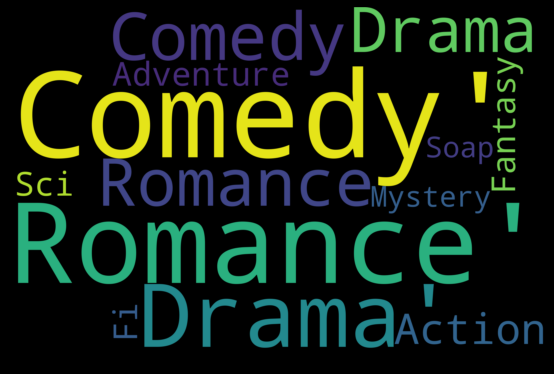

In [70]:
text = data_lake.loc[data_lake['genres'].isnull() == False][['genres']].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [56]:
df_aux = data_lake.copy()
df_aux = df_aux[df_aux['vote_average'] > 8]
# df_aux.groupby(['genres'])['genres'].count().plot(kind='barh')
df_aux['count'] = 0
df_aux = df_aux[['genres', 'count']].groupby(['genres']).count().reset_index()
df_aux = df_aux[df_aux['count'] > 5]


Text(0.5, 1.0, 'count')

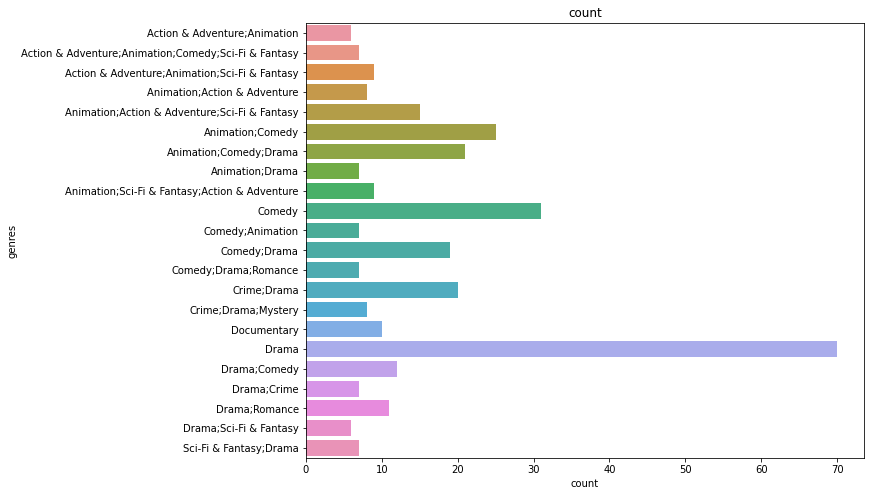

In [53]:
plt.figure(figsize=(10,8))
sns.barplot(x='count', y='genres', data=df_aux).set_title('count')
#Entendemos que dentre os gêneros dos filmes melhor avaliados, destacam-se para indicação os filmes que possuem 
# comédia ou drama na sua classificação de gênero